In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import json
import requests
import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from collections import Counter
from textblob import TextBlob
import torch
from torch import nn
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoModel
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\iyeng\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


device(type='cuda')

## Cleaning and splitting
Skip to bottom to read in final CSVs

In [2]:
full_data = pd.read_csv('full_data.csv')
full_data.head()

submission_title  \
0  Shashi Tharoor Set To Run For Congress Preside...   
1  Yogi government puts Kolkata's image as part o...   
2  An attempt to address the list of "simplified"...   
3   You guys noticing what's happening in Sri Lanka?   
4  Just got abused on the train by a hyper-nation...   

                                             comment comment_id  \
0  Extremely valid points but I believe he has th...    ip5g6vu   
1  Even if the ad was designed by the newspaper -...    hcontm8   
2  Diverse population including Muslims. Welcomin...    fbhlv40   
3  >The blockade was done by your own people.\n\n...    i2yrud3   
4  Ohoo bahut bura laga ye sunke ki aap Undergarm...    hooi92k   

                                                 url subreddit_id  label1  \
0  /r/india/comments/xif8wm/shashi_tharoor_set_to...        2qh1q      -1   
1  /r/india/comments/pmn9o3/yogi_government_puts_...        2qh1q      -1   
2  /r/india/comments/ebdeup/an_attempt_to_address...        2qh1q      -1   
3  /r/india/comments/tt1ryh/you_guys_noticing_wha...        2qh1q       0   
4  /r/india/comments/rh2kcs/just_got_abused_on_th...        2qh1q      -2   

   label2  
0      -1  
1      -1  
2      -2  
3       0  
4      -2

In [3]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   submission_title  3000 non-null   object
 1   comment           3000 non-null   object
 2   comment_id        3000 non-null   object
 3   url               3000 non-null   object
 4   subreddit_id      3000 non-null   object
 5   label1            3000 non-null   int64 
 6   label2            3000 non-null   int64 
dtypes: int64(2), object(5)
memory usage: 164.2+ KB


In [4]:
def clean_quotations(text):
    temp = re.sub(r'>.*?\n', '', text)
    return temp
def clean_url(text):
    temp = re.sub(r'(http(s)?:\/\/.)?(www\.)?[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+\.~#?&\/=]*)', '', text)
    return temp
def clean_text(text):
    temp = clean_quotations(text)
    temp = clean_url(temp)
    temp = re.sub('\’', "\'", temp)  # apostrophe formatting is occasionally incorrect
    temp = re.sub(r'[^a-zA-Z0-9\s\.,?!\'\"]', ' ', temp)
    temp = re.sub(r'\s+', ' ', temp)  # replace multiple spaces with single space
    return temp.strip()

In [5]:
full_clean_df = pd.DataFrame()
full_clean_df['clean_title'] = full_data.apply(lambda x: clean_text(x['submission_title']), axis=1)
full_clean_df['clean_comment'] = full_data.apply(lambda x: clean_text(x['comment']), axis=1)
full_clean_df[['comment_id', 'url']] = full_data[['comment_id', 'url']].copy()
full_clean_df['target'] = full_data.apply(lambda x: np.mean([x['label1'], x['label2']])/2, axis=1)
# making sure to remove comments that are empty after cleaning
full_clean_df['clean_comment'].replace('', np.nan, inplace=True)
full_clean_df.dropna(inplace=True)
full_clean_df.head()

clean_title  \
0  Shashi Tharoor Set To Run For Congress Preside...   
1  Yogi government puts Kolkata's image as part o...   
2  An attempt to address the list of "simplified"...   
3   You guys noticing what's happening in Sri Lanka?   
4  Just got abused on the train by a hyper nation...   

                                       clean_comment comment_id  \
0  Extremely valid points but I believe he has th...    ip5g6vu   
1  Even if the ad was designed by the newspaper t...    hcontm8   
2  Diverse population including Muslims. Welcomin...    fbhlv40   
3  What a joke. They didn't create any propaganda...    i2yrud3   
4  Ohoo bahut bura laga ye sunke ki aap Undergarm...    hooi92k   

                                                 url  target  
0  /r/india/comments/xif8wm/shashi_tharoor_set_to...   -0.50  
1  /r/india/comments/pmn9o3/yogi_government_puts_...   -0.50  
2  /r/india/comments/ebdeup/an_attempt_to_address...   -0.75  
3  /r/india/comments/tt1ryh/you_guys_noticing_wha...    0.00  
4  /r/india/comments/rh2kcs/just_got_abused_on_th...   -1.00

In [6]:
full_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2999 entries, 0 to 2999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   clean_title    2999 non-null   object 
 1   clean_comment  2999 non-null   object 
 2   comment_id     2999 non-null   object 
 3   url            2999 non-null   object 
 4   target         2999 non-null   float64
dtypes: float64(1), object(4)
memory usage: 140.6+ KB


In [7]:
temp = full_clean_df.sample(frac=1, random_state=123).reset_index(drop=True)  # shuflling before split
eval_df = temp[:1000].copy()
train_df = temp[1000:].copy().reset_index(drop=True)

In [20]:
# full_clean_df.to_csv('cleaned_full_data.csv', index=False)
# train_df.to_csv('train_full.csv', index=False)
# eval_df.to_csv('eval_full.csv', index=False)

In [8]:
# start here
train_df = pd.read_csv('train_full.csv')
eval_df = pd.read_csv('eval_full.csv')

## Rule-Based

In [9]:
right = """right wing, RW, authority, hierarchy, order, duty, tradition, reaction, nationalism, conservative, right-libertarian, \
neoconservative, imperialist, monarchist, fascist, reactionaries, traditionalist, traditional, death penalty, \
religion, Bhajpa, BJP, Shiv Sena, RSS, MNS, Sanatan, dharm, Hindutva, Islamophobia, Narendra, Modi, Amit, Shah, \
mandir, ram, valmiki, ramayan, Bharatiya, Janata, Democratic Alliance, NDA, AIADMK, Janta Dal, bhakt, CAA, NRC, hindu majority, \
hindu unity, hindu pride, nationalist, sangh, sanghi, yogi, brahmin, brahman, smriti irani, hindu rashtra, jai shri ram, \
pm cares, pmcares, adani, hindu""".lower()
left = """left wing, LW, leftists, freedom, equality, fraternity, rights, progress, reform, internationalism, anarchist, communist, socialist, \
democratic socialist, social democrat, left-libertarian, progressive, social, liberal, western, Congress, UPA, RG, mamata, \
Aam, aadmi, AAP, CPI, Welfare, Protectionism, Commies, Rahul, gandhi, indira, yatra, arvind, kejriwal, inclusivity, \
libby, libbies, sjw, libtard, hinduphobia, LGBTQ, masjid, pappu, christian, muslim, secular, minority, minorities, Shashi, Tharoor, \
gay, lesbian, transgender, trans, reservation, abrahamic""".lower()

right_terms = set(right.split(', '))
left_terms = set(left.split(', '))
len(right_terms), len(left_terms)

(62, 59)

In [10]:
vader = SentimentIntensityAnalyzer()

In [11]:
def unsupervised_prediction(clean_text):
    # rule-based scoring
    sentiment = vader.polarity_scores(clean_text)['compound']
    lw = rw = 0
    clean_text = clean_text.lower()
    for t in left_terms:
        if re.search(r'\b'+t, clean_text):
            lw += 1
    for t in right_terms:
        if re.search(r'\b'+t, clean_text):
            rw += 1
    
#     score = (rw-lw)*sentiment
    score = np.sign(rw - lw)*(abs(rw + lw)**0.05)*sentiment
    # normalize by length of text
    score /= len(clean_text.split())/20
    
    return score

def conv_to_label(val, threshold=0.1):
    # converts rule-based score to label
    if abs(val)<threshold:
        return 0.
    else:
        return np.sign(val)

In [12]:
pred_df = eval_df.copy()
pred_df['true_label'] = pred_df.apply(lambda x: np.sign(x['target']), axis=1)
pred_df['vader_score'] = pred_df.apply(lambda x: unsupervised_prediction(x['clean_comment']), axis=1)
pred_df['vader_label'] = pred_df.apply(lambda x: conv_to_label(x['vader_score'], threshold=0.01), axis=1)
pred_df.head()

clean_title  \
0  ResignModi trending in India on 1 with 200k tw...   
1  Put 'The Kashmir Files' on YouTube, everyone w...   
2  Kejriwal says 'The Kashmir Files' is a jhoothi...   
3  Government of India has Blacklisted Karl Rock ...   
4  Kejriwal says 'The Kashmir Files' is a jhoothi...   

                                       clean_comment comment_id  \
0  People tend to look down on "social media acti...    gwe056n   
1  I remember it was made to release twice, and t...    i1y3pv3   
2  Bhai delhi m hindu bht h but ye aur caste k lo...    i21haf8   
3  mahatma gandhi's shadows are fading. retards w...    h4lazw7   
4  Isn't this kejru the same guy who kept tweetin...    i1yrkwx   

                                                 url  target  true_label  \
0  /r/india/comments/n11sqc/resignmodi_trending_i...    -0.5        -1.0   
1  /r/india/comments/tmcun4/put_the_kashmir_files...     0.0         0.0   
2  /r/IndiaSpeaks/comments/tmhqqg/kejriwal_says_t...     0.5         1.0   
3  /r/india/comments/ogrc0d/government_of_india_h...    -1.0        -1.0   
4  /r/IndiaSpeaks/comments/tmhqqg/kejriwal_says_t...     0.5         1.0   

   vader_score  vader_label  
0    -0.000000          0.0  
1     0.000000          0.0  
2     0.320255          1.0  
3    -0.138984         -1.0  
4     0.000000          0.0

In [13]:
np.mean(pred_df['true_label']==pred_df['vader_label'])  # 3-class accuracy

0.519

In [14]:
confusion_matrix(pred_df['true_label'], pred_df['vader_label'])

array([[120, 133,  82],
       [ 42, 318,  54],
       [ 70, 100,  81]], dtype=int64)

In [15]:
print(classification_report(pred_df['true_label'], pred_df['vader_label'], target_names=['Left', 'Neutral', 'Right']))

              precision    recall  f1-score   support

        Left       0.52      0.36      0.42       335
     Neutral       0.58      0.77      0.66       414
       Right       0.37      0.32      0.35       251

    accuracy                           0.52      1000
   macro avg       0.49      0.48      0.48      1000
weighted avg       0.51      0.52      0.50      1000



<AxesSubplot:ylabel='Density'>

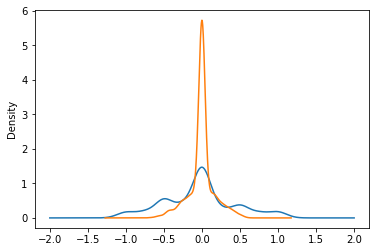

In [16]:
pred_df['target'].plot.kde()
pred_df['vader_score'].plot.kde()

In [17]:
y_rule_based = list(pred_df['vader_label']+1)

## Feature Extracted XGBoost

In [18]:
def feature_extraction(clean_text):
    clean_text = clean_text.lower()
    features = []
    for t in left_terms:
        features.append(len(re.findall(r'\b'+t, clean_text)))
    for t in right_terms:
        features.append(len(re.findall(r'\b'+t, clean_text)))
    
    return features

def add_sentiment_features(clean_text, extracted_feat):
    # appends sentiment scores onto extracted features
    temp = extracted_feat.copy()
    temp.append(vader.polarity_scores(clean_text)['compound'])
    tb = TextBlob(clean_text)
    temp.append(tb.sentiment.polarity)
    temp.append(tb.sentiment.subjectivity)
    return temp

In [19]:
# getting train embeddings
temp_df = train_df.copy()
temp_df['extracted_features'] = temp_df.apply(lambda x: feature_extraction(x['clean_comment']), axis=1)
temp_df['final_features'] = temp_df.apply(lambda x: add_sentiment_features(x['clean_comment'], x['extracted_features']), axis=1)
X_train, y_train = list(temp_df['final_features']), [np.sign(x)+1 for x in list(temp_df['target'])]

# getting eval embeddings
temp_df = eval_df.copy()
temp_df['extracted_features'] = temp_df.apply(lambda x: feature_extraction(x['clean_comment']), axis=1)
temp_df['final_features'] = temp_df.apply(lambda x: add_sentiment_features(x['clean_comment'], x['extracted_features']), axis=1)
X_test, y_test = list(temp_df['final_features']), [np.sign(x)+1 for x in list(temp_df['target'])]

print(len(X_train), len(y_train), len(X_test), len(y_test))

1999 1999 1000 1000


In [20]:
xgb = xg.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print("3-class classification accuracy:", np.mean([int(y_test[i]==y_pred[i]) for i in range(len(y_test))]))

3-class classification accuracy: 0.574


In [21]:
confusion_matrix(y_test, y_pred)

array([[138, 161,  36],
       [ 43, 364,   7],
       [ 62, 117,  72]], dtype=int64)

In [22]:
print(classification_report(y_test, y_pred, target_names=['Left', 'Neutral', 'Right']))

              precision    recall  f1-score   support

        Left       0.57      0.41      0.48       335
     Neutral       0.57      0.88      0.69       414
       Right       0.63      0.29      0.39       251

    accuracy                           0.57      1000
   macro avg       0.59      0.53      0.52      1000
weighted avg       0.58      0.57      0.54      1000



In [23]:
y_feat_ext = y_pred

## Feature Extraction with PCA

In [29]:
pca = PCA(n_components=8)

# getting train embeddings
temp_df = train_df.copy()
temp_df['extracted_features'] = temp_df.apply(lambda x: feature_extraction(x['clean_comment']), axis=1)
temp_df['extracted_features'] = pca.fit_transform(list(temp_df['extracted_features'])).tolist()  # fit transform PCA
temp_df['final_features'] = temp_df.apply(lambda x: add_sentiment_features(x['clean_comment'], x['extracted_features']), axis=1)
X_train, y_train = list(temp_df['final_features']), [np.sign(x)+1 for x in list(temp_df['target'])]

# getting eval embeddings
temp_df = eval_df.copy()
temp_df['extracted_features'] = temp_df.apply(lambda x: feature_extraction(x['clean_comment']), axis=1)
temp_df['extracted_features'] = pca.transform(list(temp_df['extracted_features'])).tolist()  # transform PCA without re-fitting
temp_df['final_features'] = temp_df.apply(lambda x: add_sentiment_features(x['clean_comment'], x['extracted_features']), axis=1)
X_test, y_test = list(temp_df['final_features']), [np.sign(x)+1 for x in list(temp_df['target'])]

print(len(X_train), len(y_train), len(X_test), len(y_test))

1999 1999 1000 1000


In [31]:
xgb = xg.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.005)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print("3-class classification accuracy:", np.mean([int(y_test[i]==y_pred[i]) for i in range(len(y_test))]))

3-class classification accuracy: 0.561


In [32]:
confusion_matrix(y_test, y_pred)

array([[168, 121,  46],
       [ 54, 327,  33],
       [ 95,  90,  66]], dtype=int64)

In [33]:
print(classification_report(y_test, y_pred, target_names=['Left', 'Neutral', 'Right']))

              precision    recall  f1-score   support

        Left       0.53      0.50      0.52       335
     Neutral       0.61      0.79      0.69       414
       Right       0.46      0.26      0.33       251

    accuracy                           0.56      1000
   macro avg       0.53      0.52      0.51      1000
weighted avg       0.54      0.56      0.54      1000



In [34]:
y_feat_pca = y_pred

## tf-idf word embeddings with XGBoost

In [35]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), analyzer='word')

X_train = vectorizer.fit_transform(list(train_df['clean_comment']))
X_test = vectorizer.transform(list(eval_df['clean_comment']))
y_train, y_test = [np.sign(x)+1 for x in list(train_df['target'])], [np.sign(x)+1 for x in list(eval_df['target'])]

print(X_train.shape, X_test.shape)

(1999, 92418) (1000, 92418)


In [36]:
# limiting the vocabulary to bigrams we know are important
count = 0

word_voc = {}
for i in vectorizer.vocabulary_:
    for t in left_terms.union(right_terms):
        if i.startswith(t):
            word_voc[i] = count
            count += 1
            break
print(word_voc)

{'order': 0, 'bjp': 1, 'aap': 2, 'congress': 3, 'order and': 4, 'bjp is': 5, 'aap or': 6, 'congress will': 7, 'shashi': 8, 'tharoor': 9, 'hindu': 10, 'shashi tharoor': 11, 'tharoor can': 12, 'hindu pakistan': 13, 'modi': 14, 'hindutva': 15, 'modi india': 16, 'modi 2014': 17, 'hindutva background': 18, 'modi 2019': 19, 'bjp managed': 20, 'bjp construction': 21, 'bjp paints': 22, 'rights': 23, 'caa': 24, 'fascist': 25, 'rights for': 26, 'caa so': 27, 'fascist agenda': 28, 'western': 29, 'trans': 30, 'nationalism': 31, 'christian': 32, 'religion': 33, 'western bigots': 34, 'western far': 35, 'trans people': 36, 'trans women': 37, 'nationalism conpiracies': 38, 'christian gladly': 39, 'religion these': 40, 'western phenomenon': 41, 'freedoms': 42, 'freedom': 43, 'secularity': 44, 'social': 45, 'freedoms prior': 46, 'freedom democracy': 47, 'secularity were': 48, 'social media': 49, 'modi is': 50, 'modi government': 51, 'modi who': 52, 'bjp hence': 53, 'bjp here': 54, 'bjp had': 55, 'transf

In [37]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), analyzer='word', vocabulary=word_voc)

X_train = vectorizer.fit_transform(list(train_df['clean_comment']))
X_test = vectorizer.transform(list(eval_df['clean_comment']))
y_train, y_test = [np.sign(x)+1 for x in list(train_df['target'])], [np.sign(x)+1 for x in list(eval_df['target'])]

print(X_train.shape, X_test.shape)

(1999, 2248) (1000, 2248)


In [38]:
xgb = xg.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.3)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print("3-class classification accuracy:", np.mean([int(y_test[i]==y_pred[i]) for i in range(len(y_test))]))

3-class classification accuracy: 0.581


In [39]:
confusion_matrix(y_test, y_pred)

array([[139, 146,  50],
       [ 31, 358,  25],
       [ 67, 100,  84]], dtype=int64)

In [40]:
print(classification_report(y_test, y_pred, target_names=['Left', 'Neutral', 'Right']))

              precision    recall  f1-score   support

        Left       0.59      0.41      0.49       335
     Neutral       0.59      0.86      0.70       414
       Right       0.53      0.33      0.41       251

    accuracy                           0.58      1000
   macro avg       0.57      0.54      0.53      1000
weighted avg       0.57      0.58      0.56      1000



In [41]:
y_w_tfidf = y_pred

## tf-idf word embeddings with PCA and sentiment
Since PCA doesn't work for sparse data, we use TruncatedSVD for the same effect

In [42]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), analyzer='word', vocabulary=word_voc)
tsvd = TruncatedSVD(n_components=200, random_state=123)

temp_df = train_df.copy()
X_train = vectorizer.fit_transform(list(temp_df['clean_comment']))
temp_df['extracted_features'] = tsvd.fit_transform(X_train).tolist()
temp_df['final_features'] = temp_df.apply(lambda x: add_sentiment_features(x['clean_comment'], x['extracted_features']), axis=1)
X_train, y_train = list(temp_df['final_features']), [np.sign(x)+1 for x in list(temp_df['target'])]

temp_df = eval_df.copy()
X_test = vectorizer.transform(list(temp_df['clean_comment']))
temp_df['extracted_features'] = tsvd.transform(X_test).tolist()
temp_df['final_features'] = temp_df.apply(lambda x: add_sentiment_features(x['clean_comment'], x['extracted_features']), axis=1)
X_test, y_test = list(temp_df['final_features']), [np.sign(x)+1 for x in list(temp_df['target'])]

In [43]:
xgb = xg.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.001)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print("3-class classification accuracy:", np.mean([int(y_test[i]==y_pred[i]) for i in range(len(y_test))]))

3-class classification accuracy: 0.572


In [44]:
confusion_matrix(y_test, y_pred)

array([[164, 121,  50],
       [ 53, 333,  28],
       [ 84,  92,  75]], dtype=int64)

In [45]:
print(classification_report(y_test, y_pred, target_names=['Left', 'Neutral', 'Right']))

              precision    recall  f1-score   support

        Left       0.54      0.49      0.52       335
     Neutral       0.61      0.80      0.69       414
       Right       0.49      0.30      0.37       251

    accuracy                           0.57      1000
   macro avg       0.55      0.53      0.53      1000
weighted avg       0.56      0.57      0.55      1000



In [46]:
y_tfidf_pca = y_pred

## tf-idf sub-word embeddings

In [47]:
vectorizer = TfidfVectorizer(ngram_range=(2, 10), analyzer='char_wb')

X_train = vectorizer.fit_transform(list(train_df['clean_comment']))
X_test = vectorizer.transform(list(eval_df['clean_comment']))
y_train, y_test = [np.sign(x)+1 for x in list(train_df['target'])], [np.sign(x)+1 for x in list(eval_df['target'])]

print(X_train.shape, X_test.shape)

(1999, 222782) (1000, 222782)


In [48]:
xgb = xg.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.05)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print("3-class classification accuracy:", np.mean([int(y_test[i]==y_pred[i]) for i in range(len(y_test))]))

3-class classification accuracy: 0.563


In [49]:
confusion_matrix(y_test, y_pred)

array([[135, 158,  42],
       [ 44, 350,  20],
       [ 55, 118,  78]], dtype=int64)

In [50]:
print(classification_report(y_test, y_pred, target_names=['Left', 'Neutral', 'Right']))

              precision    recall  f1-score   support

        Left       0.58      0.40      0.47       335
     Neutral       0.56      0.85      0.67       414
       Right       0.56      0.31      0.40       251

    accuracy                           0.56      1000
   macro avg       0.56      0.52      0.52      1000
weighted avg       0.56      0.56      0.54      1000



In [51]:
y_sw_tfidf = y_pred

## Data Augmentation with tf-idf/XGBoost
Due to the randomness of term selection, performance may vary slightly

In [52]:
list_right_terms = list(right_terms)
list_left_terms = list(left_terms)
full_terms = left_terms.union(right_terms)

In [53]:
def random_swap(term):
    if term in left_terms:
        # LW term being swapped
        return np.random.choice(list_right_terms)
    elif term in right_terms:
        # RW term being swapped
        return np.random.choice(list_left_terms)
    print(f"Error with: {term}")

def swap_terms(text):
    term_match = re.compile('|'.join([r'\b'+t for t in full_terms]))
    
    temp = term_match.sub(lambda m: random_swap(m.group()), text.lower())
    return temp

In [62]:
aug_records = []
for i, row in train_df.iterrows():
    aug_records.append({'clean_comment':row['clean_comment'].lower(), 'target':row['target']})
    # adding in record with swapped terms and opposite score
    aug_records.append({'clean_comment':swap_terms(row['clean_comment']), 'target':-row['target']})
aug_df = pd.DataFrame.from_records(aug_records)
aug_df

clean_comment  target
0     there are two types of parties those that prom...    0.00
1     there are two types of parties those that prom...   -0.00
2     if fundamentals are sound then, faith can help...    0.75
3     if fundamentals are sound then, faith can help...   -0.75
4     contrary to popular belief, until modi, india ...   -0.50
...                                                 ...     ...
3993  it is good a initiative but the plastic in roa...   -0.00
3994  yup, been reading about it since couple of wee...    0.00
3995  yup, been reading about it since couple of wee...   -0.00
3996  first i thought christmas ke chakkar me. then ...    0.00
3997  first i thought christmas ke chakkar me. then ...   -0.00

[3998 rows x 2 columns]

In [63]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), analyzer='word', vocabulary=word_voc)

X_train = vectorizer.fit_transform(list(aug_df['clean_comment']))
X_test = vectorizer.transform(list(eval_df['clean_comment']))
y_train, y_test = [np.sign(x)+1 for x in list(aug_df['target'])], [np.sign(x)+1 for x in list(eval_df['target'])]

print(X_train.shape, X_test.shape)

(3998, 2248) (1000, 2248)


In [67]:
xgb = xg.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print("3-class classification accuracy:", np.mean([int(y_test[i]==y_pred[i]) for i in range(len(y_test))]))

3-class classification accuracy: 0.566


In [68]:
confusion_matrix(y_test, y_pred)

array([[128, 163,  44],
       [ 26, 370,  18],
       [ 54, 129,  68]], dtype=int64)

In [69]:
print(classification_report(y_test, y_pred, target_names=['Left', 'Neutral', 'Right']))

              precision    recall  f1-score   support

        Left       0.62      0.38      0.47       335
     Neutral       0.56      0.89      0.69       414
       Right       0.52      0.27      0.36       251

    accuracy                           0.57      1000
   macro avg       0.57      0.52      0.51      1000
weighted avg       0.57      0.57      0.53      1000



In [70]:
y_aug = y_pred

## Frozen Indian-sBERT embeddings with XGBoost
### Note: do NOT re-run this section without a powerful GPU. The pretrained model is massive.

In [71]:
model_name = "meedan/indian-sbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)

# freezing everything
modules = [model.embeddings, *model.encoder.layer]
for module in modules:
    for param in module.parameters():
        param.requires_grad = False

In [72]:
# getting train embeddings from model
with torch.no_grad():
    model.eval()
    X_train = []
    batch_size = 16
    for i in range(0, len(train_df), batch_size):
        temp = tokenizer(list(train_df['clean_comment'][i:i+batch_size]), padding='max_length', max_length = 256, truncation=True, return_tensors="pt")
        X_train.extend(model(temp['input_ids'].to(device), temp['attention_mask'].to(device)).pooler_output.cpu().detach().numpy().tolist())
      
print(len(X_train), len(X_train[0]))

1999 768


In [73]:
# getting eval embeddings from model
with torch.no_grad():
    model.eval()
    X_test = []
    batch_size = 16
    for i in range(0, len(eval_df), batch_size):
        temp = tokenizer(list(eval_df['clean_comment'][i:i+batch_size]), padding='max_length', max_length = 256, truncation=True, return_tensors="pt")
        X_test.extend(model(temp['input_ids'].to(device), temp['attention_mask'].to(device)).pooler_output.cpu().detach().numpy().tolist())
      
print(len(X_test), len(X_test[0]))

1000 768


In [74]:
y_train, y_test = [np.sign(x)+1 for x in list(train_df['target'])], [np.sign(x)+1 for x in list(eval_df['target'])]

In [75]:
xgb = xg.XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print("3-class classification accuracy:", np.mean([int(y_test[i]==y_pred[i]) for i in range(len(y_test))]))

3-class classification accuracy: 0.518


In [76]:
confusion_matrix(y_test, y_pred)

array([[149, 123,  63],
       [ 82, 296,  36],
       [ 77, 101,  73]], dtype=int64)

In [77]:
print(classification_report(y_test, y_pred, target_names=['Left', 'Neutral', 'Right']))

              precision    recall  f1-score   support

        Left       0.48      0.44      0.46       335
     Neutral       0.57      0.71      0.63       414
       Right       0.42      0.29      0.35       251

    accuracy                           0.52      1000
   macro avg       0.49      0.48      0.48      1000
weighted avg       0.50      0.52      0.50      1000



In [78]:
y_bert_frozen = y_pred

# 2-step model

In [79]:
# getting senticnet toxicity scores

base_api = "http://sentic.net/api/en/%s.py?text=%s"
polarity_key = "zfCm4Hq4p0lgOJNU"
absa_key = "xSK04b5TqYH2"
toxicity_key = "TLHqwt0xWpvVG"

# Calculate toxicity of comment
def toxicity(text):
    x = requests.get(base_api % (toxicity_key, text))
    for _ in range(3):
        try:
            raw_value = float(x.text.strip('%\n'))/100
            return raw_value
        except:
            continue
    print(f"Error with: {text}")
    return 0

# try:
#     for i, row in text_df.iterrows():
#         if np.isnan(row['toxicity']):
#             row['toxicity'] = toxicity(row['clean_comment'])
#             text_df.iloc[i] = row

#     text_df.to_csv('train_subset_toxicity.csv', index=False)

# except:
#     print("Error")
#     text_df.to_csv('train_subset_toxicity_incomplete.csv')

In [80]:
tox_full_df = pd.read_csv('train_subset_toxicity.csv')
tox_full_df.head()

clean_title  \
0  shashi tharoor set to run for congress preside...   
1  yogi government puts kolkata s image as part o...   
2  an attempt to address the list of simplified e...   
3   you guys noticing what s happening in sri lanka    
4  just got abused on the train by a hyper nation...   

                                       clean_comment  \
0  extremely valid points but i believe he has th...   
1  even if the ad was designed by the newspaper t...   
2  diverse population including muslims welcoming...   
3   what a joke they didn t create any propaganda...   
4  ohoo bahut bura laga ye sunke ki aap undergarm...   

                                                 url  avg_score  toxicity  
0  /r/india/comments/xif8wm/shashi_tharoor_set_to...       -1.0      0.00  
1  /r/india/comments/pmn9o3/yogi_government_puts_...       -1.0      0.00  
2  /r/india/comments/ebdeup/an_attempt_to_address...       -1.0      0.00  
3  /r/india/comments/tt1ryh/you_guys_noticing_wha...        0.0      0.00  
4  /r/india/comments/rh2kcs/just_got_abused_on_th...       -2.0      0.66

In [81]:
# use urls to match with train and eval dfs
tox_train_df = train_df.merge(tox_full_df[['url', 'toxicity']], how='left', left_on='url', right_on='url', validate='one_to_one')
tox_eval_df = eval_df.merge(tox_full_df[['url', 'toxicity']], how='left', left_on='url', right_on='url', validate='one_to_one')

In [82]:
tox_train_df['left_features'] = tox_train_df.apply(lambda x: sum(feature_extraction(x['clean_comment'])[:len(left_terms)]), axis=1)
tox_train_df['right_features'] = tox_train_df.apply(lambda x: sum(feature_extraction(x['clean_comment'])[len(left_terms):]), axis=1)
tox_train_df['sentiment_features'] = tox_train_df.apply(lambda x: vader.polarity_scores(x['clean_comment'])['compound'], axis=1)
tox_train_df.head()

clean_title  \
0                        BJP Gujarat 2022 Manifesto.   
1  Rajasthan BJP MLA Sanjay Sharma posted this on...   
2  The new Indian If Trump's supporters blame Ant...   
3  Kejriwal says that Mukesh Ambani's Antilia is ...   
4  The picture pretty much sums up the ideology o...   

                                       clean_comment comment_id  \
0  There are two types of parties those that prom...    iy20u35   
1  If fundamentals are sound then, faith can help...    hnc96s6   
2  Contrary to popular belief, until Modi, India ...    giqnuc2   
3  Bro inhone bahut land hijack kiya hai kisse pa...    iq3l8o5   
4  The 1.9 million denied citizenship in Assam al...    fbtqycg   

                                                 url  target  toxicity  \
0  /r/IndiaSpeaks/comments/z5u6kf/bjp_gujarat_202...    0.00      0.33   
1  /r/IndiaSpeaks/comments/r9df3s/rajasthan_bjp_m...    0.75      0.33   
2  /r/india/comments/ku5i9f/the_new_indian_if_tru...   -0.50      0.00   
3  /r/IndiaSpeaks/comments/xpb83d/kejriwal_says_t...   -0.25      0.00   
4  /r/india/comments/ee11sp/the_picture_pretty_mu...   -1.00      0.00   

   left_features  right_features  sentiment_features  
0              2               2              0.9699  
1              2               1              0.8937  
2              0               8              0.4215  
3              0               0             -0.8720  
4              1               2             -0.0387

In [83]:
tox_eval_df['left_features'] = tox_eval_df.apply(lambda x: sum(feature_extraction(x['clean_comment'])[:len(left_terms)]), axis=1)
tox_eval_df['right_features'] = tox_eval_df.apply(lambda x: sum(feature_extraction(x['clean_comment'])[len(left_terms):]), axis=1)
tox_eval_df['sentiment_features'] = tox_eval_df.apply(lambda x: vader.polarity_scores(x['clean_comment'])['compound'], axis=1)
tox_eval_df.head()

clean_title  \
0  ResignModi trending in India on 1 with 200k tw...   
1  Put 'The Kashmir Files' on YouTube, everyone w...   
2  Kejriwal says 'The Kashmir Files' is a jhoothi...   
3  Government of India has Blacklisted Karl Rock ...   
4  Kejriwal says 'The Kashmir Files' is a jhoothi...   

                                       clean_comment comment_id  \
0  People tend to look down on "social media acti...    gwe056n   
1  I remember it was made to release twice, and t...    i1y3pv3   
2  Bhai delhi m hindu bht h but ye aur caste k lo...    i21haf8   
3  mahatma gandhi's shadows are fading. retards w...    h4lazw7   
4  Isn't this kejru the same guy who kept tweetin...    i1yrkwx   

                                                 url  target  toxicity  \
0  /r/india/comments/n11sqc/resignmodi_trending_i...    -0.5      0.00   
1  /r/india/comments/tmcun4/put_the_kashmir_files...     0.0      0.00   
2  /r/IndiaSpeaks/comments/tmhqqg/kejriwal_says_t...     0.5      0.00   
3  /r/india/comments/ogrc0d/government_of_india_h...    -1.0      0.33   
4  /r/IndiaSpeaks/comments/tmhqqg/kejriwal_says_t...     0.5      0.00   

   left_features  right_features  sentiment_features  
0              4               1             -0.5594  
1              0               0              0.5849  
2              0               1              0.8807  
3              2               5             -0.2960  
4              0               0              0.4404

In [145]:
X_train = tox_train_df[['clean_comment', 'toxicity', 'left_features', 'right_features', 'sentiment_features']].copy()
y_train = pd.Series([np.sign(x)+1 for x in list(tox_train_df['target'])])
X_test = tox_eval_df[['clean_comment', 'toxicity', 'left_features', 'right_features', 'sentiment_features']].copy()
y_test = pd.Series([np.sign(x)+1 for x in list(tox_eval_df['target'])])

X_train_step1 = X_train.copy()
X_test_step1 = X_test.copy()
y_train_step1 = pd.Series([1-abs(np.sign(x)) for x in list(tox_train_df['target'])])
y_test_step1 = pd.Series([1-abs(np.sign(x)) for x in list(tox_eval_df['target'])])

# Define the preprocessing steps for the text and float features
text_transformer = TfidfVectorizer(ngram_range=(1, 2), analyzer='word', vocabulary=word_voc)

# Combine the preprocessing steps using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('text', text_transformer, 'clean_comment'),
        ('num', StandardScaler(), ['left_features', 'right_features'])
    ], remainder='passthrough')

# Step 1: Predict neutral or non-neutral
pipeline_step1 = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', xg.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.05))
])
pipeline_step1.fit(X_train_step1, y_train_step1)

# Predictions of step 1
y_pred_step1 = pipeline_step1.predict(X_test_step1)

# Print the classification report for the 1st predictions
print(classification_report(y_test_step1, y_pred_step1, target_names=['Non-neutral', 'Neutral']))

              precision    recall  f1-score   support

 Non-neutral       0.79      0.72      0.75       586
     Neutral       0.65      0.72      0.68       414

    accuracy                           0.72      1000
   macro avg       0.72      0.72      0.72      1000
weighted avg       0.73      0.72      0.72      1000



In [146]:
# Step 2: Predict left or right based on the output of step 1

X_train_step2 = X_train[y_train != 1]
X_train_step2 = X_train_step2[['clean_comment']]#, 'left_features', 'right_features']]
y_train_step2 = y_train[y_train != 1]//2
# X_train_step2, y_train_step2 = rus.fit_resample(X_train_step2, y_train_step2)

X_test_step2 = X_test[y_pred_step1 != 1]
X_test_step2 = X_test_step2[['clean_comment']]#, 'left_features', 'right_features']]
# y_test_step2 = y_test[y_pred_step1 != 1]

# Define the preprocessing steps for the text and float features
text_transformer = TfidfVectorizer(max_features=20_000, analyzer='char_wb', ngram_range=(3,7))

# Combine the preprocessing steps using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('text', text_transformer, 'clean_comment')
        # ('num', StandardScaler(), ['left_features', 'right_features'])
    ], remainder='passthrough')

# Step 2: Predict left or right
pipeline_step2 = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', xg.XGBClassifier(n_estimators=100, max_depth=10, learning_rate=0.05))
])
pipeline_step2.fit(X_train_step2, y_train_step2)

# Predictions of step 2
y_pred_step2 = pipeline_step2.predict(X_test_step2)

# Combine the predictions of step 1 and step 2
y_pred_step2 = y_pred_step2*2
y_pred = y_pred_step1.copy()
y_pred[y_pred_step1 != 1] = y_pred_step2

# Print the classification report for the combined predictions
print(classification_report(y_test, y_pred, target_names=['Left', 'Neutral', 'Right']))

              precision    recall  f1-score   support

        Left       0.51      0.53      0.52       335
     Neutral       0.65      0.72      0.68       414
       Right       0.47      0.35      0.41       251

    accuracy                           0.57      1000
   macro avg       0.54      0.54      0.54      1000
weighted avg       0.56      0.57      0.56      1000



In [86]:
y_2step = y_pred

## Ensemble of Models

In [ ]:
# we have the models and accuracies:
# y_rule_based    0.519
# y_feat_ext      0.574
# y_feat_pca      0.562
# y_w_tfidf       0.581
# y_tfidf_pca     0.572
# y_sw_tfidf      0.563
# y_aug           0.541
# y_bert_frozen   0.518
# y_2step         0.57

In [87]:
def majority_voting(pred_list):
    # provide in decreasing order of confidence for tie-breaks
    n = len(pred_list[0])
    y_ensembled = []
    for i in range(n):
        temp = [x[i] for x in pred_list]
        y_ensembled.append(Counter(temp).most_common(1)[0][0])
    return y_ensembled

In [88]:
# y_ensembled = majority_voting([y_feat_ext, y_sw_tfidf, y_feat_pca, y_aug, y_w_tfidf, y_bert_frozen, y_rule_based, y_tfidf_pca])
y_ensembled = majority_voting([y_w_tfidf, y_feat_ext, y_tfidf_pca, y_2step, y_sw_tfidf, y_feat_pca, y_aug])
y_test = [np.sign(x)+1 for x in list(eval_df['target'])]
y_pred = y_ensembled
print("3-class classification accuracy:", np.mean([int(y_test[i]==y_pred[i]) for i in range(len(y_test))]))

3-class classification accuracy: 0.591


In [89]:
confusion_matrix(y_test, y_pred)

array([[159, 143,  33],
       [ 41, 358,  15],
       [ 71, 106,  74]], dtype=int64)

In [90]:
print(classification_report(y_test, y_pred, target_names=['Left', 'Neutral', 'Right']))

              precision    recall  f1-score   support

        Left       0.59      0.47      0.52       335
     Neutral       0.59      0.86      0.70       414
       Right       0.61      0.29      0.40       251

    accuracy                           0.59      1000
   macro avg       0.59      0.54      0.54      1000
weighted avg       0.59      0.59      0.57      1000



In [91]:
def weighted_avg(pred_list):
    # pred_list should contain tuples of (y_pred, weight)
    n = len(pred_list[0][0])
    y_ensembled = []
    weight_sum = sum([m[1] for m in pred_list])
    for i in range(n):
        score = 0
        for m in pred_list:
            score += m[0][i]*m[1]/weight_sum
        y_ensembled.append(score-1)
    return y_ensembled

In [139]:
y_ensembled = weighted_avg([(y_w_tfidf, 6), 
                            (y_feat_ext, 6), 
                            (y_tfidf_pca, 5), 
                            (y_sw_tfidf, 5), 
                            (y_feat_pca, 5),
                            (y_2step, 6),
                            (y_aug, 3), 
                            (y_rule_based, 0), 
                            (y_bert_frozen, 0)])

(array([ 96.,  57.,  61.,  81., 104., 488.,  43.,  21.,  16.,  33.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

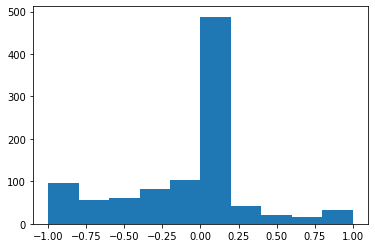

In [121]:
plt.hist(y_ensembled)

<AxesSubplot:ylabel='Density'>

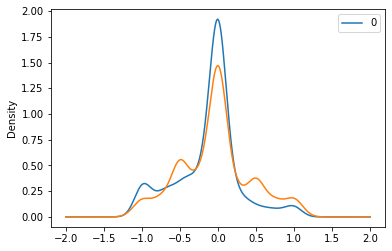

In [122]:
pd.DataFrame(y_ensembled).plot.kde()
eval_df['target'].plot.kde()

In [140]:
# y_pred = [conv_to_label(x, threshold=0.1)+1 for x in y_ensembled]
y_pred = [1 if -0.2<x<0.1 else np.sign(x)+1 for x in y_ensembled]
print("3-class classification accuracy:", np.mean([int(y_test[i]==y_pred[i]) for i in range(len(y_test))]))

3-class classification accuracy: 0.589


In [141]:
confusion_matrix(y_test, y_pred)

array([[174, 119,  42],
       [ 51, 327,  36],
       [ 70,  93,  88]], dtype=int64)

In [142]:
print(classification_report(y_test, y_pred, target_names=['Left', 'Neutral', 'Right']))

              precision    recall  f1-score   support

        Left       0.59      0.52      0.55       335
     Neutral       0.61      0.79      0.69       414
       Right       0.53      0.35      0.42       251

    accuracy                           0.59      1000
   macro avg       0.58      0.55      0.55      1000
weighted avg       0.58      0.59      0.58      1000



## Propagating results of ensemble

In [126]:
with open('backup_before_reindex.json', 'r') as fileobj:
    full_records = json.load(fileobj)

In [127]:
full_records[:3]

[{'submission_id': 'zpre2v',
  'submission_title': '"2 Judges Can\'t Decide": BJP MP\'s Strong Objection On Same-Sex Marriages',
  'subreddit_id': '3d4x4',
  'subreddit_name': 't5_3d4x4',
  'comment_id': 'j0uassz',
  'comment': 'Lets take the argument that its not provided in Indian culture. OK, SO WHAT ? There is no provision saying we have to live according to Indian culture only. We have to live according to our rights and duties in the Constitution and the laws based on it. Dont make Gay Marriage in Hindu Marriage Act, but Special Marriage Act exists so that non-dharmic marriages can exist. Whats the problem there ? Forcing people to live according to your culture is tyranny.',
  'timestamp': '2022-12-19T21:58:40',
  'url': '/r/IndiaSpeaks/comments/zpre2v/2_judges_cant_decide_bjp_mps_strong_objection_on/j0uassz/',
  'reddit_score': 68,
  'redditor_id': 'bu6k2huu',
  'id': '4b5f4c75-9914-4a6d-be95-5b753d4200e6',
  '_version_': 1760900444169699328},
 {'submission_id': 'zpre2v',
  'su

In [128]:
cids = []
comments = []
for record in full_records:
    cids.append(record['comment_id'])
    comments.append(clean_text(record['comment']))
final_preds = pd.DataFrame.from_dict({'comment_id':cids, 'clean_comment':comments})
final_preds['clean_comment'].replace('', np.nan, inplace=True)
final_preds.dropna(inplace=True)
final_preds

comment_id                                      clean_comment
0       j0uassz  Lets take the argument that its not provided i...
1       j0vbu5s  Bullshit. If same sex wants to get married the...
2       j0wkxz5  I don't support this MP's views culture has op...
3       j0w3jyf  Mark my words, BJP is building the nation with...
4       j0uq3k8  Ok tbh is he...? And on top of all how favouri...
...         ...                                                ...
6674    ffqq001  the 20 have drunk the koolaid. In the last ele...
6675    ffq6zn1  Not really possible. Rest of India, elections ...
6676    ffq9dxt  I think that cant be further from the truth. S...
6677    ffqcpfc  If they focused on campaigning in urban areas ...
6678    ffqa1nt  They tried really hard in Maharashtra. Anajali...

[6674 rows x 2 columns]

In [129]:
# feature extraction model

# getting train embeddings
temp_df = train_df.copy()
temp_df['extracted_features'] = temp_df.apply(lambda x: feature_extraction(x['clean_comment']), axis=1)
temp_df['final_features'] = temp_df.apply(lambda x: add_sentiment_features(x['clean_comment'], x['extracted_features']), axis=1)
X_train, y_train = list(temp_df['final_features']), [np.sign(x)+1 for x in list(temp_df['target'])]

# getting prediction embeddings
temp_df = final_preds.copy()
temp_df['extracted_features'] = temp_df.apply(lambda x: feature_extraction(x['clean_comment']), axis=1)
temp_df['final_features'] = temp_df.apply(lambda x: add_sentiment_features(x['clean_comment'], x['extracted_features']), axis=1)
X_eval = list(temp_df['final_features'])

print(len(X_train), len(y_train), len(X_eval))

xgb = xg.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1)
xgb.fit(X_train, y_train)
final_preds['y_feat_ext'] = xgb.predict(X_eval)
final_preds.head()

1999 1999 6674


comment_id                                      clean_comment  y_feat_ext
0    j0uassz  Lets take the argument that its not provided i...           0
1    j0vbu5s  Bullshit. If same sex wants to get married the...           1
2    j0wkxz5  I don't support this MP's views culture has op...           1
3    j0w3jyf  Mark my words, BJP is building the nation with...           0
4    j0uq3k8  Ok tbh is he...? And on top of all how favouri...           1

In [130]:
# feature extraction with pca and sentiment

pca = PCA(n_components=8)

# getting train embeddings
temp_df = train_df.copy()
temp_df['extracted_features'] = temp_df.apply(lambda x: feature_extraction(x['clean_comment']), axis=1)
temp_df['extracted_features'] = pca.fit_transform(list(temp_df['extracted_features'])).tolist()  # fit transform PCA
temp_df['final_features'] = temp_df.apply(lambda x: add_sentiment_features(x['clean_comment'], x['extracted_features']), axis=1)
X_train, y_train = list(temp_df['final_features']), [np.sign(x)+1 for x in list(temp_df['target'])]

# getting prediction embeddings
temp_df = final_preds.copy()
temp_df['extracted_features'] = temp_df.apply(lambda x: feature_extraction(x['clean_comment']), axis=1)
temp_df['extracted_features'] = pca.transform(list(temp_df['extracted_features'])).tolist()  # transform PCA without re-fitting
temp_df['final_features'] = temp_df.apply(lambda x: add_sentiment_features(x['clean_comment'], x['extracted_features']), axis=1)
X_eval = list(temp_df['final_features'])

print(len(X_train), len(y_train), len(X_eval))

xgb = xg.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.005)
xgb.fit(X_train, y_train)
final_preds['y_feat_pca'] = xgb.predict(X_eval)
final_preds.head()

1999 1999 6674


comment_id                                      clean_comment  y_feat_ext  \
0    j0uassz  Lets take the argument that its not provided i...           0   
1    j0vbu5s  Bullshit. If same sex wants to get married the...           1   
2    j0wkxz5  I don't support this MP's views culture has op...           1   
3    j0w3jyf  Mark my words, BJP is building the nation with...           0   
4    j0uq3k8  Ok tbh is he...? And on top of all how favouri...           1   

   y_feat_pca  
0           2  
1           1  
2           0  
3           0  
4           0

In [131]:
# word level tfidf

vectorizer = TfidfVectorizer(ngram_range=(1, 2), analyzer='word', vocabulary=word_voc)

X_train = vectorizer.fit_transform(list(train_df['clean_comment']))
X_eval = vectorizer.transform(list(final_preds['clean_comment']))
y_train = [np.sign(x)+1 for x in list(train_df['target'])]

print(X_train.shape, X_eval.shape)

xgb = xg.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.3)
xgb.fit(X_train, y_train)
final_preds['y_w_tfidf'] = xgb.predict(X_eval)
final_preds.head()

(1999, 2248) (6674, 2248)


comment_id                                      clean_comment  y_feat_ext  \
0    j0uassz  Lets take the argument that its not provided i...           0   
1    j0vbu5s  Bullshit. If same sex wants to get married the...           1   
2    j0wkxz5  I don't support this MP's views culture has op...           1   
3    j0w3jyf  Mark my words, BJP is building the nation with...           0   
4    j0uq3k8  Ok tbh is he...? And on top of all how favouri...           1   

   y_feat_pca  y_w_tfidf  
0           2          0  
1           1          1  
2           0          0  
3           0          0  
4           0          0

In [132]:
# word tfidf with pca and sentiment

vectorizer = TfidfVectorizer(ngram_range=(1, 2), analyzer='word', vocabulary=word_voc)
tsvd = TruncatedSVD(n_components=200, random_state=123)

temp_df = train_df.copy()
X_train = vectorizer.fit_transform(list(temp_df['clean_comment']))
temp_df['extracted_features'] = tsvd.fit_transform(X_train).tolist()
temp_df['final_features'] = temp_df.apply(lambda x: add_sentiment_features(x['clean_comment'], x['extracted_features']), axis=1)
X_train, y_train = list(temp_df['final_features']), [np.sign(x)+1 for x in list(temp_df['target'])]

temp_df = final_preds.copy()
X_eval = vectorizer.transform(list(temp_df['clean_comment']))
temp_df['extracted_features'] = tsvd.transform(X_eval).tolist()
temp_df['final_features'] = temp_df.apply(lambda x: add_sentiment_features(x['clean_comment'], x['extracted_features']), axis=1)
X_eval = list(temp_df['final_features'])

xgb = xg.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.001)
xgb.fit(X_train, y_train)
final_preds['y_tfidf_pca'] = xgb.predict(X_eval)
final_preds.head()

comment_id                                      clean_comment  y_feat_ext  \
0    j0uassz  Lets take the argument that its not provided i...           0   
1    j0vbu5s  Bullshit. If same sex wants to get married the...           1   
2    j0wkxz5  I don't support this MP's views culture has op...           1   
3    j0w3jyf  Mark my words, BJP is building the nation with...           0   
4    j0uq3k8  Ok tbh is he...? And on top of all how favouri...           1   

   y_feat_pca  y_w_tfidf  y_tfidf_pca  
0           2          0            1  
1           1          1            1  
2           0          0            0  
3           0          0            0  
4           0          0            0

In [133]:
# subword tfidf

vectorizer = TfidfVectorizer(ngram_range=(2, 10), analyzer='char_wb')

X_train = vectorizer.fit_transform(list(train_df['clean_comment']))
X_eval = vectorizer.transform(list(final_preds['clean_comment']))
y_train = [np.sign(x)+1 for x in list(train_df['target'])]

print(X_train.shape, X_eval.shape)

xgb = xg.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.05)
xgb.fit(X_train, y_train)
final_preds['y_sw_tfidf'] = xgb.predict(X_eval)
final_preds.head()

(1999, 222782) (6674, 222782)


comment_id                                      clean_comment  y_feat_ext  \
0    j0uassz  Lets take the argument that its not provided i...           0   
1    j0vbu5s  Bullshit. If same sex wants to get married the...           1   
2    j0wkxz5  I don't support this MP's views culture has op...           1   
3    j0w3jyf  Mark my words, BJP is building the nation with...           0   
4    j0uq3k8  Ok tbh is he...? And on top of all how favouri...           1   

   y_feat_pca  y_w_tfidf  y_tfidf_pca  y_sw_tfidf  
0           2          0            1           0  
1           1          1            1           1  
2           0          0            0           0  
3           0          0            0           0  
4           0          0            0           1

In [134]:
# augmented data

vectorizer = TfidfVectorizer(ngram_range=(1, 2), analyzer='word', vocabulary=word_voc)

X_train = vectorizer.fit_transform(list(aug_df['clean_comment']))
X_eval = vectorizer.transform(list(final_preds['clean_comment']))
y_train = [np.sign(x)+1 for x in list(aug_df['target'])]

print(X_train.shape, X_eval.shape)

xgb = xg.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1)
xgb.fit(X_train, y_train)
final_preds['y_aug'] = xgb.predict(X_eval)
final_preds.head()

(3998, 2248) (6674, 2248)


comment_id                                      clean_comment  y_feat_ext  \
0    j0uassz  Lets take the argument that its not provided i...           0   
1    j0vbu5s  Bullshit. If same sex wants to get married the...           1   
2    j0wkxz5  I don't support this MP's views culture has op...           1   
3    j0w3jyf  Mark my words, BJP is building the nation with...           0   
4    j0uq3k8  Ok tbh is he...? And on top of all how favouri...           1   

   y_feat_pca  y_w_tfidf  y_tfidf_pca  y_sw_tfidf  y_aug  
0           2          0            1           0      2  
1           1          1            1           1      1  
2           0          0            0           0      1  
3           0          0            0           0      0  
4           0          0            0           1      0

In [352]:
# frozen bert embeddings

# getting train embeddings from model
# with torch.no_grad():
#     model.eval()
#     X_train = []
#     batch_size = 16
#     for i in range(0, len(train_df), batch_size):
#         temp = tokenizer(list(train_df['clean_comment'][i:i+batch_size]), padding='max_length', max_length = 256, truncation=True, return_tensors="pt")
#         X_train.extend(model(temp['input_ids'].to(device), temp['attention_mask'].to(device)).pooler_output.cpu().detach().numpy().tolist())
      
# print(len(X_train), len(X_train[0]))

# # getting prediction embeddings from model
# with torch.no_grad():
#     model.eval()
#     X_eval = []
#     batch_size = 16
#     for i in range(0, len(final_preds), batch_size):
#         temp = tokenizer(list(final_preds['clean_comment'][i:i+batch_size]), padding='max_length', max_length = 256, truncation=True, return_tensors="pt")
#         X_eval.extend(model(temp['input_ids'].to(device), temp['attention_mask'].to(device)).pooler_output.cpu().detach().numpy().tolist())
      
# print(len(X_eval), len(X_eval[0]))

# y_train = [np.sign(x)+1 for x in list(train_df['target'])]

# xgb = xg.XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1)
# xgb.fit(X_train, y_train)
# final_preds['y_bert_frozen'] = xgb.predict(X_eval)
# final_preds.head()

1999 768
6674 768


comment_id                                      clean_comment  y_feat_ext  \
0    j0uassz  Lets take the argument that its not provided i...           0   
1    j0vbu5s  Bullshit. If same sex wants to get married the...           1   
2    j0wkxz5  I don't support this MP's views culture has op...           1   
3    j0w3jyf  Mark my words, BJP is building the nation with...           0   
4    j0uq3k8  Ok tbh is he...? And on top of all how favouri...           1   

   y_feat_pca  y_w_tfidf  y_sw_tfidf  y_aug  y_bert_frozen  
0           2          1           0      1              0  
1           1          1           1      1              0  
2           0          1           0      0              0  
3           0          0           0      0              0  
4           0          1           1      1              0

In [148]:
# 2-step model

temp_df = train_df.copy()
temp_df['left_features'] = temp_df.apply(lambda x: sum(feature_extraction(x['clean_comment'])[:len(left_terms)]), axis=1)
temp_df['right_features'] = temp_df.apply(lambda x: sum(feature_extraction(x['clean_comment'])[len(left_terms):]), axis=1)
temp_df['sentiment_features'] = temp_df.apply(lambda x: vader.polarity_scores(x['clean_comment'])['compound'], axis=1)

X_train = temp_df[['clean_comment', 'left_features', 'right_features', 'sentiment_features']].copy()
y_train = pd.Series([np.sign(x)+1 for x in list(temp_df['target'])])


# Train step 1
X_train_step1 = X_train.copy()
y_train_step1 = pd.Series([1-abs(np.sign(x)) for x in list(temp_df['target'])])
print(len(X_train_step1), len(y_train_step1))

# Define the preprocessing steps for the text and float features
text_transformer = TfidfVectorizer(ngram_range=(1, 2), analyzer='word', vocabulary=word_voc)

# Combine the preprocessing steps using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('text', text_transformer, 'clean_comment'),
        ('num', StandardScaler(), ['left_features', 'right_features'])
    ], remainder='passthrough')

# Step 1: Predict neutral or non-neutral
pipeline_step1 = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', xg.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.05))
])
pipeline_step1.fit(X_train_step1, y_train_step1)


# Train step 2
X_train_step2 = X_train[y_train != 1]
X_train_step2 = X_train_step2[['clean_comment']]
y_train_step2 = y_train[y_train != 1]//2
print(len(X_train_step2), len(y_train_step2))

# Define the preprocessing steps for the text and float features
text_transformer = TfidfVectorizer(max_features=20_000, analyzer='char_wb', ngram_range=(3,7))

# Combine the preprocessing steps using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('text', text_transformer, 'clean_comment')
        # ('num', StandardScaler(), ['left_features', 'right_features'])
    ], remainder='passthrough')

# Step 2: Predict left or right
pipeline_step2 = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', xg.XGBClassifier(n_estimators=100, max_depth=10, learning_rate=0.05))
])
pipeline_step2.fit(X_train_step2, y_train_step2)


# Predictions
temp_df = final_preds.copy()
temp_df['left_features'] = temp_df.apply(lambda x: sum(feature_extraction(x['clean_comment'])[:len(left_terms)]), axis=1)
temp_df['right_features'] = temp_df.apply(lambda x: sum(feature_extraction(x['clean_comment'])[len(left_terms):]), axis=1)
temp_df['sentiment_features'] = temp_df.apply(lambda x: vader.polarity_scores(x['clean_comment'])['compound'], axis=1)
X_eval = temp_df[['clean_comment', 'left_features', 'right_features', 'sentiment_features']].copy()

X_eval_step1 = X_eval.copy()
y_pred_step1 = pipeline_step1.predict(X_eval_step1)
X_eval_step2 = X_eval[y_pred_step1 != 1]
X_eval_step2 = X_eval_step2[['clean_comment']]
y_pred_step2 = pipeline_step2.predict(X_eval_step2)

# Combine the predictions of step 1 and step 2
y_pred_step2 = y_pred_step2*2
y_pred = y_pred_step1.copy()
y_pred[y_pred_step1 != 1] = y_pred_step2

final_preds['y_2step'] = y_pred.copy()
final_preds.head()

1999 1999
1158 1158


comment_id                                      clean_comment  y_feat_ext  \
0    j0uassz  Lets take the argument that its not provided i...           0   
1    j0vbu5s  Bullshit. If same sex wants to get married the...           1   
2    j0wkxz5  I don't support this MP's views culture has op...           1   
3    j0w3jyf  Mark my words, BJP is building the nation with...           0   
4    j0uq3k8  Ok tbh is he...? And on top of all how favouri...           1   

   y_feat_pca  y_w_tfidf  y_tfidf_pca  y_sw_tfidf  y_aug  y_2step  
0           2          0            1           0      2        0  
1           1          1            1           1      1        1  
2           0          0            0           0      1        0  
3           0          0            0           0      0        0  
4           0          0            0           1      0        0

In [149]:
final_preds.describe()

y_feat_ext   y_feat_pca    y_w_tfidf  y_tfidf_pca   y_sw_tfidf  \
count  6674.000000  6674.000000  6674.000000  6674.000000  6674.000000   
mean      0.867696     0.799670     0.907702     0.875037     0.878933   
std       0.576030     0.648132     0.612711     0.654187     0.608174   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       1.000000     0.000000     1.000000     0.000000     0.000000   
50%       1.000000     1.000000     1.000000     1.000000     1.000000   
75%       1.000000     1.000000     1.000000     1.000000     1.000000   
max       2.000000     2.000000     2.000000     2.000000     2.000000   

             y_aug      y_2step  
count  6674.000000  6674.000000  
mean      0.913096     0.834882  
std       0.570465     0.717995  
min       0.000000     0.000000  
25%       1.000000     0.000000  
50%       1.000000     1.000000  
75%       1.000000     1.000000  
max       2.000000     2.000000

In [150]:
def final_ensemble(row):
    score = row['y_feat_ext']*6 + row['y_feat_pca']*5 + row['y_w_tfidf']*6 + row['y_tfidf_pca']*5 + row['y_sw_tfidf']*5 + row['y_aug']*3 + row['y_2step']*6
    score /= (6+5+6+5+5+3+6)
    return score-1

final_preds['predicted_score'] = final_preds.apply(lambda x: final_ensemble(x), axis=1)
final_preds['predicted_label'] = final_preds.apply(lambda x: (0 if -0.2<x['predicted_score']<0.1 else np.sign(x['predicted_score'])), axis=1)
final_preds.head()

comment_id                                      clean_comment  y_feat_ext  \
0    j0uassz  Lets take the argument that its not provided i...           0   
1    j0vbu5s  Bullshit. If same sex wants to get married the...           1   
2    j0wkxz5  I don't support this MP's views culture has op...           1   
3    j0w3jyf  Mark my words, BJP is building the nation with...           0   
4    j0uq3k8  Ok tbh is he...? And on top of all how favouri...           1   

   y_feat_pca  y_w_tfidf  y_tfidf_pca  y_sw_tfidf  y_aug  y_2step  \
0           2          0            1           0      2        0   
1           1          1            1           1      1        1   
2           0          0            0           0      1        0   
3           0          0            0           0      0        0   
4           0          0            0           1      0        0   

   predicted_score  predicted_label  
0        -0.416667             -1.0  
1         0.000000              0.0  
2        -0.750000             -1.0  
3        -1.000000             -1.0  
4        -0.694444             -1.0

<AxesSubplot:ylabel='Density'>

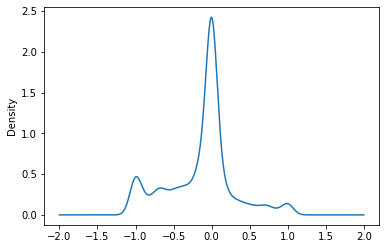

In [151]:
final_preds['predicted_score'].plot.kde()

In [152]:
temp_df = final_preds[['comment_id', 'clean_comment', 'predicted_score', 'predicted_label']].copy()
temp_df.head()

comment_id                                      clean_comment  \
0    j0uassz  Lets take the argument that its not provided i...   
1    j0vbu5s  Bullshit. If same sex wants to get married the...   
2    j0wkxz5  I don't support this MP's views culture has op...   
3    j0w3jyf  Mark my words, BJP is building the nation with...   
4    j0uq3k8  Ok tbh is he...? And on top of all how favouri...   

   predicted_score  predicted_label  
0        -0.416667             -1.0  
1         0.000000              0.0  
2        -0.750000             -1.0  
3        -1.000000             -1.0  
4        -0.694444             -1.0

In [153]:
temp_df.to_csv('full_6k_preds.csv', index=False)